In [13]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np

In [14]:
def show_images(images, filename=None, save=False, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    if save == True:
        filename = filename
        cv2.imwrite(filename, image)

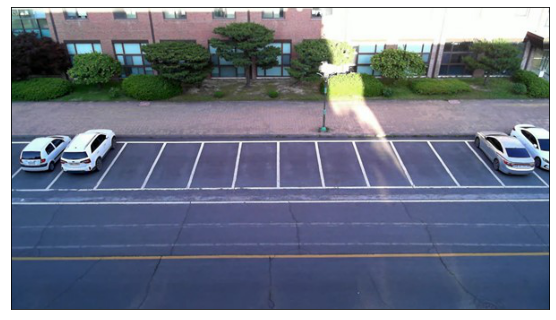

In [15]:
test_images = [plt.imread(path) for path in glob.glob('test_images/Img.jpg')]

show_images(test_images)

### Color Selection and Edge Detection

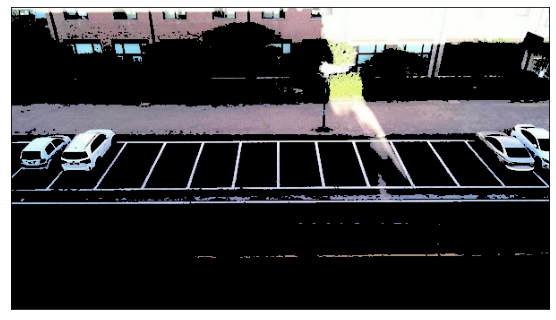

In [16]:
# image is expected be in RGB color space# image 
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([120, 120, 120])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

white_yellow_images = list(map(select_rgb_white_yellow, test_images))
filename = 'white_yellow_image.jpg'
show_images(white_yellow_images, filename, True, None)

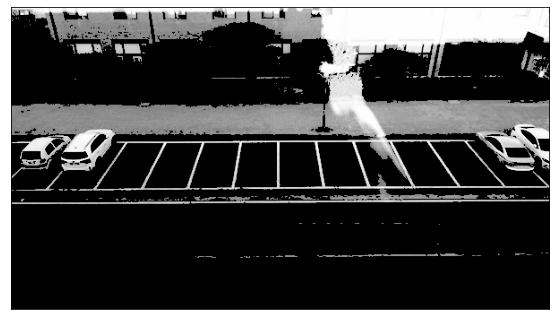

In [17]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

filename = 'gray_image.jpg'
show_images(gray_images, filename, True, None)

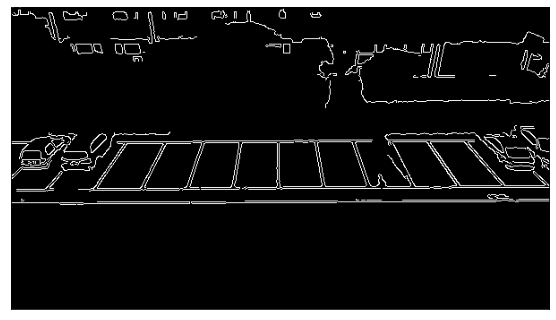

In [18]:
def detect_edges(image, low_threshold=500, high_threshold=1000):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), gray_images))

filename = 'edge_image.jpg'
show_images(edge_images, filename, True, None)

### Identify area of interest

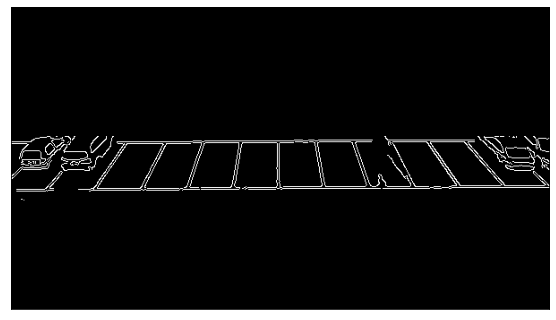

In [19]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    pt_1  = [cols*0.0, rows*0.43]
    pt_2 = [cols*0.0, rows*0.64]
    pt_3 = [cols*1, rows*0.6]
    pt_4 = [cols*1, rows*0.43]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4]], dtype=np.int32)
    return filter_region(image, vertices)

# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

filename = 'roi_image.jpg'
show_images(roi_images, filename, True, None)

### Hough line transform

In [20]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)


list_of_lines = list(map(hough_lines, roi_images))
# print(list_of_lines)

 No lines detected:  18


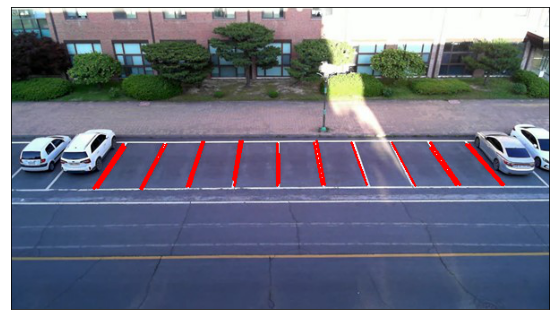

In [21]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) >=10 and abs(x2-x1) >=0 and abs(x2-x1) <= 10000:
                cleaned.append((x1,y1,x2,y2))
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    print(" No lines detected: ", len(cleaned))
    return image

line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

filename = 'line_image.jpg'  
show_images(line_images, filename, True, None)

### Identify rectangular blocks of parking

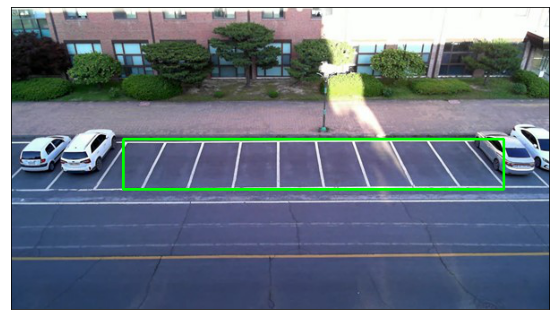

In [22]:
def identify_blocks(image, lines, make_copy=True):
    if make_copy:
        new_image = np.copy(image)
    #Step 1: Create a clean list of lines
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) >=10 and abs(x2-x1) >=0 and abs(x2-x1) <= 100000:
                cleaned.append((x1,y1,x2,y2))
    
    #Step 2: Sort cleaned by y1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(1, 1))
    
    #Step 3: Find clusters of y1 close together - clust_dist apart
    clusters = {}
    dIndex = 0
    clus_dist = 1000

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][1] - list1[i][1])
        # print(distance)
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])

        else:
            dIndex += 1
    
    #Step 4: Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > 10:
            cleaned = sorted(cleaned, key=lambda tup: tup[0])
            avg_x1 = cleaned[0][2]
            avg_x2 = cleaned[-1][2]
    #         print(avg_y1, avg_y2)
            avg_y1 = 0
            avg_y2 = 0
            for tup in cleaned:
                if tup[1] > tup[-1]:
                    avg_y1 += tup[-1]
                    avg_y2 += tup[1]
                else:
                    avg_y1 += tup[1]
                    avg_y2 += tup[-1]

            avg_y1 = avg_y1/len(cleaned)
            avg_y2 = avg_y2/len(cleaned)
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
    
    #Step 5: Draw the rectangles on the image
    buff = 5
    for key in rects:
        tup_topLeft = (int(rects[key][0]), int(rects[key][1]- buff))
        tup_botRight = (int(rects[key][2]), int(rects[key][3] + buff))
#         print(tup_topLeft, tup_botRight)
        cv2.rectangle(new_image, tup_topLeft, tup_botRight, (0,255,0), 2)
    return new_image, rects

# images showing the region of interest only
rect_images = []
rect_coords = []
for image, lines in zip(test_images, list_of_lines):
    new_image, rects = identify_blocks(image, lines)
    rect_images.append(new_image)
    rect_coords.append(rects)

filename = 'rect_image.jpg'
show_images(rect_images, filename, True, None)

### Identify each spot and count num of parking spaces

Next step- 
1. Based on width of each parking line segment into individual spots
2. draw a visualization of all parking spaces

total parking spaces:  13 11


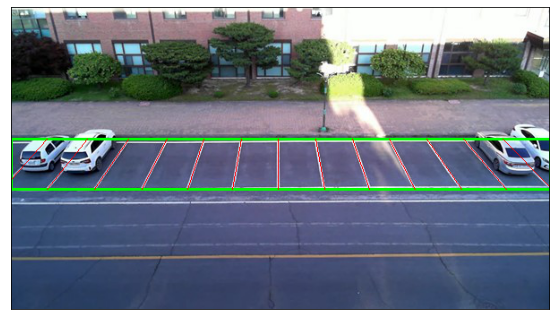

In [23]:
def draw_parking(image, rects, make_copy = True, color=[255, 0, 0], thickness=1, save = True):
    if make_copy:
        new_image = np.copy(image)
    rows, cols = image.shape[:2]
    gap = cols / 12 - 0.1
    adj_gap_x1 = {0:40, 1:35, 2:31, 3:24, 4:15, 5:7, 6:-2, 7:-10, 8:-19, 9:-28, 10:-36, 11:-45, 12:-51 }
    adj_gap_x2 = {0:-10, 1:-10, 2:-7, 3:-4, 4:-3, 5:-3, 6:-2, 7:0, 8:0, 9:1, 10:3, 11:3, 12:4 }
    spot_dict = {} # maps each parking ID to its coords
    poly_dict = {}
    tot_spots = 0

    adj_x1 = {0:(0 - rects[0][0])}
    adj_x2 = {0:(cols - rects[0][2])}

    adj_y1 = {0:-5}
    adj_y2 = {0:5}

    for key in rects:
        # Horizontal lines
        tup = rects[key]
        x1 = int(tup[0]+ adj_x1[key])
        x2 = int(tup[2]+ adj_x2[key])
        y1 = int(tup[1] + adj_y1[key])
        y2 = int(tup[3] + adj_y2[key])
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
        num_splits = int(abs(x2-x1)//gap)
        for i in range(0, num_splits+1):
            x = int(x1 + i*gap)
            cv2.line(new_image, (x + adj_gap_x1[i], y1), (x + adj_gap_x2[i], y2), color, thickness)
        if key > 0 and key < len(rects) -1 :        
            #draw vertical lines
            y = int((y1 + y2)/2)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
        # Add up spots in this lane
        if key == 0 or key == (len(rects) -1):
            tot_spots += num_splits +1
        else:
            tot_spots += 2*(num_splits +1)
            
        # Dictionary of spot positions
        if key == 0 or key == (len(rects) -1):
            for i in range(0, num_splits):
                cur_len = len(spot_dict)
                x = int(x1 + i*gap)
                spot_dict[(x + adj_gap_x1[i], y1, x + gap + adj_gap_x2[i+1], y2)] = cur_len +1
                poly_dict[(x + adj_gap_x1[i], y1, x + adj_gap_x2[i], y2, x + gap + adj_gap_x2[i+1], y2, x + gap + adj_gap_x1[i+1], y1)] = cur_len +1
        else:
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                x = int(x1 + i*gap)
                y = int((y1 + y2)/2)
                spot_dict[(x, y1, x+gap, y)] = cur_len +1
                spot_dict[(x, y, x+gap, y2)] = cur_len +2   
    
    print("total parking spaces: ", tot_spots, cur_len)
    if save:
        filename = 'with_parking.jpg'
        cv2.imwrite(filename, new_image)
    return new_image, poly_dict

delineated = []
spot_pos = []
for image, rects in zip(test_images, rect_coords):
    new_image, poly_dict = draw_parking(image, rects)
    delineated.append(new_image)
    spot_pos.append(poly_dict)

filename = 'delineated_image.jpg'
show_images(delineated, filename, True, None)

In [24]:
final_spot_dict = spot_pos[0]

In [25]:
print(len(final_spot_dict))

12


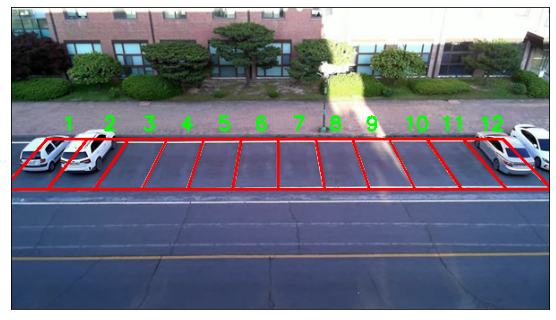

In [26]:
def assign_spots_map(image, spot_dict=final_spot_dict, make_copy = True, color=[255, 0, 0], thickness=2):
    spot_cnt = 1
    if make_copy:
        new_image = np.copy(image)
            
        for spot in spot_dict.keys():
            (x1, y1, x2, y2, x3, y3, x4, y4) = spot
            poly_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype = np.int32).reshape((-1,1,2))
            cv2.polylines(new_image, [poly_points], 1, color, thickness)
            text_coordinate = int((x1+x4)/2 - 5) , int(y1- 10)
            cv2.putText(new_image, "%d" %spot_cnt, text_coordinate, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            spot_cnt += 1
    return new_image

marked_spot_images = list(map(assign_spots_map, test_images))
filename = 'marked_spot_images.jpg'
show_images(marked_spot_images, filename, True, None)